In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score

In [3]:
trainpath='/content/gdrive/MyDrive/YBIGTA_CreditAI/open/train.csv'
testpath='/content/gdrive/MyDrive/YBIGTA_CreditAI/open/test.csv'
valpath='/content/gdrive/MyDrive/YBIGTA_CreditAI/open/val.csv'
submissionpath= '/content/gdrive/MyDrive/YBIGTA_CreditAI/open/sample_submission.csv'
trainsmotepath= '/content/gdrive/MyDrive/YBIGTA_CreditAI/open/train_smote.csv'

train=pd.read_csv(trainpath)
test=pd.read_csv(testpath)
val=pd.read_csv(valpath)
submission=pd.read_csv(submissionpath)
train_smote = pd.read_csv(trainsmotepath)

In [4]:
train = train.drop(columns=['ID'])
val_class = val.Class
val = val.drop(columns=['ID', 'Class'])
test = test.drop(columns=['ID'])

In [5]:
ele = EllipticEnvelope(support_fraction = 0.994, contamination = 0.00112, random_state = 22)
ele.fit(train)

EllipticEnvelope(contamination=0.00112, random_state=22, support_fraction=0.994)

In [6]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [7]:
val_pred = get_pred_label(ele.predict(val))
f1_score(val_class, val_pred, average='macro') #0.9236496787663914

0.9236496787663914

In [8]:
#trainX = train_smote.drop(columns=['Class'])
#trainY = train_smote.Class

In [9]:
train['Class'] = ele.predict(train)

In [10]:
train['Class'] = get_pred_label(train['Class'])

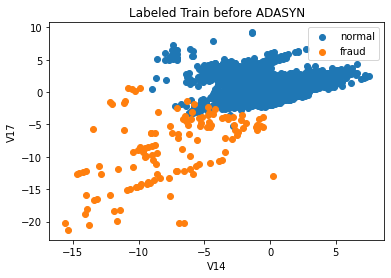

In [13]:
plt.scatter(train[train.Class==0]['V14'], train[train.Class==0]['V17'], label='normal')
plt.scatter(train[train.Class==1]['V14'], train[train.Class==1]['V17'],label='fraud')

plt.title('Labeled Train before ADASYN')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()
plt.show()

In [11]:
from imblearn.over_sampling import ADASYN

In [12]:
ada = ADASYN(random_state=22)

trainX_resampled_adasyn, trainY_resampled_adasyn = ada.fit_resample(train.drop(columns=['Class']), train.Class)

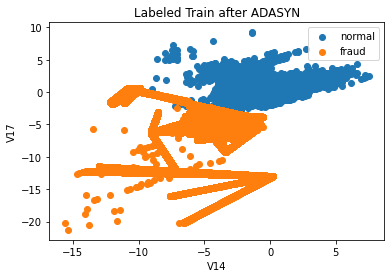

In [14]:
plt.scatter(trainX_resampled_adasyn[trainY_resampled_adasyn==0]['V14'], trainX_resampled_adasyn[trainY_resampled_adasyn==0]['V17'], label='normal')
plt.scatter(trainX_resampled_adasyn[trainY_resampled_adasyn==1]['V14'], trainX_resampled_adasyn[trainY_resampled_adasyn==1]['V17'],label='fraud')

plt.title('Labeled Train after ADASYN')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()
plt.show()

In [ ]:
train_adasyn= pd.concat([trainX_resampled_adasyn, trainY_resampled_adasyn], axis=1)

In [ ]:
train_adasyn.to_csv('train_adasyn.csv', index=False)

In [15]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import tree
from sklearn.ensemble import VotingClassifier

In [16]:
xgb = XGBClassifier(n_estimators=2000, max_depth=6, subsample=0.5, learning_rate=0.1, objective='binary:logistic', random_state=0)

In [17]:
xgb.fit(trainX_resampled_adasyn, trainY_resampled_adasyn)

XGBClassifier(max_depth=6, n_estimators=2000, subsample=0.5)

In [18]:
val_pred_xgb = xgb.predict(val)

In [19]:
f1_score(val_class, val_pred_xgb, average='macro')

0.9165787375726882

In [20]:
val_prob_xgb = xgb.predict_proba(val)

In [21]:
val_prob_xgb

array([[9.9999857e-01, 1.4549086e-06],
       [9.9999762e-01, 2.3899634e-06],
       [9.9999803e-01, 1.9483564e-06],
       ...,
       [9.9999440e-01, 5.5954738e-06],
       [9.9999905e-01, 9.3513756e-07],
       [9.9999851e-01, 1.4678753e-06]], dtype=float32)

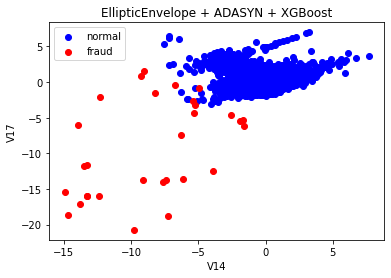

In [23]:
plt.scatter(val[val_pred_xgb==0]['V14'], val[val_pred_xgb==0]['V17'], color='blue', label='normal')
plt.scatter(val[val_pred_xgb==1]['V14'], val[val_pred_xgb==1]['V17'], color='red', label='fraud')

plt.title('EllipticEnvelope + ADASYN + XGBoost')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

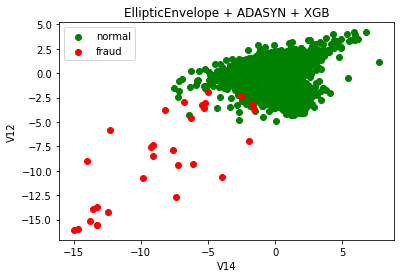

In [ ]:
plt.scatter(val[val_pred_xgb==0]['V14'], val[val_pred_xgb==0]['V12'], color='green', label='normal')
plt.scatter(val[val_pred_xgb==1]['V14'], val[val_pred_xgb==1]['V12'], color='red', label='fraud')

plt.title('EllipticEnvelope + ADASYN + XGB')
plt.xlabel('V14')
plt.ylabel('V12')

plt.legend()

plt.show()

In [ ]:
train_smote

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972,0
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972,0
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960,0
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901,0
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227495,-2.870317,1.002704,-3.929599,4.235764,1.158891,-2.211052,-4.689516,1.282881,-3.242726,-5.228506,...,0.007671,-0.008208,-0.468530,0.351525,-0.049075,0.969862,0.584658,-0.242253,0.326006,1
227496,-13.136956,7.380241,-18.219379,10.584352,-11.780569,-3.635695,-14.857328,8.832773,-5.479335,-13.229996,...,-0.261749,-0.413578,0.519940,-0.702859,-0.161592,-2.474822,-0.721608,0.206915,0.091424,1
227497,-2.130029,1.393243,-0.610282,1.097765,-1.145266,-0.779364,-2.004996,0.578112,-0.990660,-2.506929,...,0.718471,-0.159213,-0.044114,0.267863,-0.459835,-0.385126,-0.143749,-0.037942,-0.419416,1
227498,-1.278324,2.445764,-2.816353,2.337650,-1.357786,-0.952941,-3.054281,1.160062,-2.255877,-4.852642,...,0.077456,-0.223092,-0.512078,0.224557,0.744227,0.630954,0.249745,-0.307275,-0.325846,1


In [24]:
lgbm = LGBMClassifier(learning_rate=0.01)

In [25]:
lgbm.fit(train_smote.drop(columns=['Class']), train_smote.Class)

LGBMClassifier(learning_rate=0.01)

In [26]:
val_pred_lgbm = lgbm.predict(val)

In [27]:
f1_score(val_class, val_pred_lgbm, average='macro')

0.9106263628050926

In [28]:
val_prob_lgbm = lgbm.predict_proba(val)

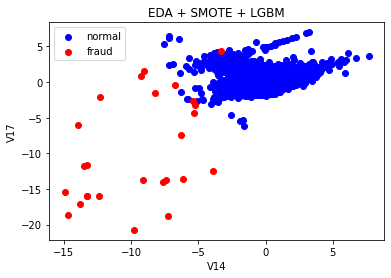

In [29]:
plt.scatter(val[val_pred_lgbm==0]['V14'], val[val_pred_lgbm==0]['V17'], color='blue', label='normal')
plt.scatter(val[val_pred_lgbm==1]['V14'], val[val_pred_lgbm==1]['V17'], color='red', label='fraud')

plt.title('EDA + SMOTE + LGBM')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

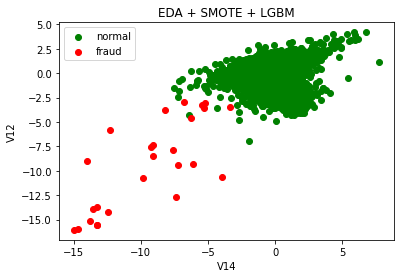

In [ ]:
plt.scatter(val[val_pred_lgbm==0]['V14'], val[val_pred_lgbm==0]['V12'], color='green', label='normal')
plt.scatter(val[val_pred_lgbm==1]['V14'], val[val_pred_lgbm==1]['V12'], color='red', label='fraud')

plt.title('EDA + SMOTE + LGBM')
plt.xlabel('V14')
plt.ylabel('V12')

plt.legend()

plt.show()

In [30]:
ensem = (val_prob_xgb + val_prob_lgbm)/2

In [31]:
prediction = []

for i in range(len(ensem)):
  if ensem[i][0] > ensem[i][1]:
    prediction.append(0)
  else:
    prediction.append(1)

In [32]:
f1_score(val_class,prediction, average='macro')

0.9236496787663914

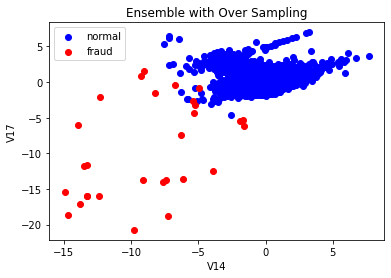

In [33]:
plt.scatter(val[np.array(prediction)==0]['V14'], val[np.array(prediction)==0]['V17'], color='blue', label='normal')
plt.scatter(val[np.array(prediction)==1]['V14'], val[np.array(prediction)==1]['V17'], color='red', label='fraud')

plt.title('Ensemble with Over Sampling')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

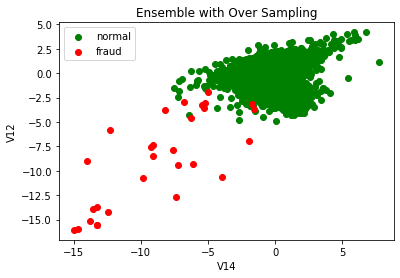

In [ ]:
plt.scatter(val[np.array(prediction)==0]['V14'], val[np.array(prediction)==0]['V12'], color='green', label='normal')
plt.scatter(val[np.array(prediction)==1]['V14'], val[np.array(prediction)==1]['V12'], color='red', label='fraud')

plt.title('Ensemble with Over Sampling')
plt.xlabel('V14')
plt.ylabel('V12')

plt.legend()

plt.show()

In [ ]:
test_prob_xgb = xgb.predict_proba(test)

In [ ]:
test_prob_lgbm = lgbm.predict_proba(test)

In [ ]:
test_ensem = (test_prob_xgb + test_prob_lgbm)/2

In [ ]:
test_prediction = []

for i in range(len(test_ensem)):
  if test_ensem[i][0] > test_ensem[i][1]:
    test_prediction.append(0)
  else:
    test_prediction.append(1)

In [ ]:
submission.Class = test_prediction

In [ ]:
submission.to_csv('submission_oversampling_ensemble.csv', index=False)

In [50]:
train['Class'] = ((train.V14 + train.V17 + 10) < 0)

In [51]:
train['Class'] = train['Class'].astype(int)

In [52]:
from imblearn.over_sampling import BorderlineSMOTE

border_smote = BorderlineSMOTE(random_state=22)

trainX_resampled2, trainY_resampled2 = border_smote.fit_resample(train.drop(columns=['Class']), train.Class)

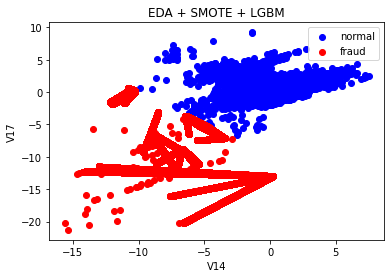

In [53]:
plt.scatter(trainX_resampled2[trainY_resampled2==0]['V14'], trainX_resampled2[trainY_resampled2==0]['V17'], color='blue', label='normal')
plt.scatter(trainX_resampled2[trainY_resampled2==1]['V14'], trainX_resampled2[trainY_resampled2==1]['V17'], color='red', label='fraud')

plt.title('EDA + SMOTE + LGBM')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

In [72]:
lgbm2 = XGBClassifier(n_estimators=2000, max_depth=6, subsample=0.5, learning_rate=0.1, objective='binary:logistic', random_state=0)

In [73]:
lgbm2.fit(trainX_resampled2, trainY_resampled2)

XGBClassifier(max_depth=6, n_estimators=2000, subsample=0.5)

In [74]:
val_pred_lgbm2 = lgbm2.predict(val)

In [75]:
f1_score(val_class, val_pred_lgbm2, average='macro')

0.9073194875902806

In [76]:
val_prob_lgbm2 = lgbm2.predict_proba(val)

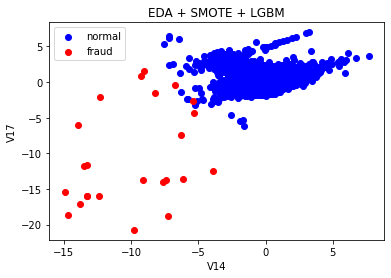

In [77]:
plt.scatter(val[val_pred_lgbm2==0]['V14'], val[val_pred_lgbm2==0]['V17'], color='blue', label='normal')
plt.scatter(val[val_pred_lgbm2==1]['V14'], val[val_pred_lgbm2==1]['V17'], color='red', label='fraud')

plt.title('EDA + SMOTE + LGBM')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

In [88]:
ensem2 = 0.55*val_prob_xgb + 0.45*val_prob_lgbm2

In [89]:
prediction2 = []

for i in range(len(ensem2)):
  if ensem2[i][0] > ensem2[i][1]:
    prediction2.append(0)
  else:
    prediction2.append(1)

In [90]:
f1_score(val_class,prediction2, average='macro')

0.9236496787663914

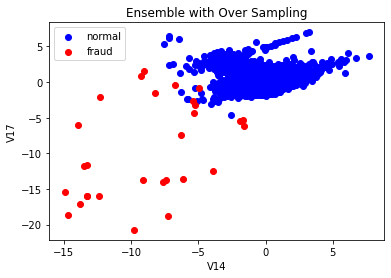

In [91]:
plt.scatter(val[np.array(prediction2)==0]['V14'], val[np.array(prediction2)==0]['V17'], color='blue', label='normal')
plt.scatter(val[np.array(prediction2)==1]['V14'], val[np.array(prediction2)==1]['V17'], color='red', label='fraud')

plt.title('Ensemble with Over Sampling')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

In [92]:
test_prob_xgb = xgb.predict_proba(test)

In [93]:
test_prob_lgbm2 = lgbm2.predict_proba(test)

In [94]:
test_ensem2 = 0.55*test_prob_xgb + 0.45*test_prob_lgbm2

In [95]:
test_prediction2 = []

for i in range(len(test_ensem2)):
  if test_ensem2[i][0] > test_ensem2[i][1]:
    test_prediction2.append(0)
  else:
    test_prediction2.append(1)

In [96]:
submission.Class = test_prediction2

In [100]:
ss = pd.read_csv('submission_oversampling_ensemble.csv')

In [104]:
sum(ss.Class == test_prediction2)/len(test_prediction2)

0.999992982603875

In [105]:
submission.to_csv('submission_oversampling_ensemble2.csv', index=False)

In [106]:
ada2 = ADASYN(random_state=22)

trainX_resampled_adasyn2, trainY_resampled_adasyn2 = ada2.fit_resample(train.drop(columns=['Class']), train.Class)

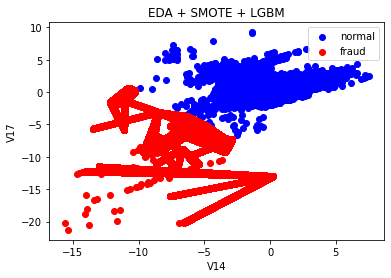

In [107]:
plt.scatter(trainX_resampled_adasyn2[trainY_resampled_adasyn2==0]['V14'], trainX_resampled_adasyn2[trainY_resampled_adasyn2==0]['V17'], color='blue', label='normal')
plt.scatter(trainX_resampled_adasyn2[trainY_resampled_adasyn2==1]['V14'], trainX_resampled_adasyn2[trainY_resampled_adasyn2==1]['V17'], color='red', label='fraud')

plt.title('EDA + SMOTE + LGBM')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

In [108]:
lgbm3 = LGBMClassifier(learning_rate=0.01)

In [109]:
lgbm3.fit(trainX_resampled_adasyn2, trainY_resampled_adasyn2)

LGBMClassifier(learning_rate=0.01)

In [112]:
val_pred_lgbm3 = lgbm3.predict(val)

In [113]:
f1_score(val_class, val_pred_lgbm3, average='macro')

0.9106263628050926

In [114]:
val_prob_lgbm3 = lgbm3.predict_proba(val)

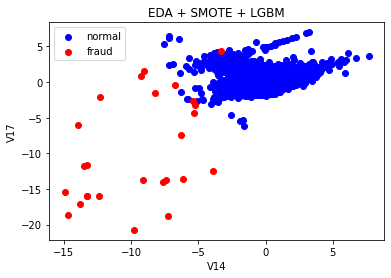

In [115]:
plt.scatter(val[val_pred_lgbm3==0]['V14'], val[val_pred_lgbm3==0]['V17'], color='blue', label='normal')
plt.scatter(val[val_pred_lgbm3==1]['V14'], val[val_pred_lgbm3==1]['V17'], color='red', label='fraud')

plt.title('EDA + SMOTE + LGBM')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

In [137]:
ensem2 = 0.4*val_prob_xgb + 0.6*val_prob_lgbm2

In [138]:
prediction2 = []

for i in range(len(ensem2)):
  if ensem2[i][0] > ensem2[i][1]:
    prediction2.append(0)
  else:
    prediction2.append(1)

In [139]:
f1_score(val_class,prediction2, average='macro')

0.928501090244074

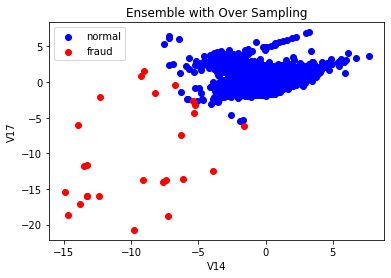

In [140]:
plt.scatter(val[np.array(prediction2)==0]['V14'], val[np.array(prediction2)==0]['V17'], color='blue', label='normal')
plt.scatter(val[np.array(prediction2)==1]['V14'], val[np.array(prediction2)==1]['V17'], color='red', label='fraud')

plt.title('Ensemble with Over Sampling')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

In [116]:
#test_prob_xgb = xgb.predict_proba(test)

In [117]:
test_prob_lgbm3 = lgbm3.predict_proba(test)

In [141]:
test_ensem3 = 0.4*test_prob_xgb + 0.6*test_prob_lgbm3

In [142]:
test_prediction3 = []

for i in range(len(test_ensem3)):
  if test_ensem3[i][0] > test_ensem3[i][1]:
    test_prediction3.append(0)
  else:
    test_prediction3.append(1)

In [144]:
submission.Class = test_prediction3

In [145]:
submission.to_csv('submission_oversampling_ensemble3.csv', index=False)

In [ ]:
ss = pd.read_csv('submission_oversampling_ensembl.csv')

In [146]:
sum(test_prediction2 == test_prediction3)/len(test_prediction3)

TypeError: ignored

In [150]:
num = 0
for i in range(len(test_prediction2)):
  if test_prediction2[i] == test_prediction3[i]:
    num += 1

In [151]:
num/len(test_prediction2)

0.99998596520775

In [156]:
xgb2 =LGBMClassifier(n_estimators=2000, max_depth=6, subsample=0.5, learning_rate=0.01, objective='binary', random_state=0)

In [157]:
xgb2.fit(trainX_resampled_adasyn2, trainY_resampled_adasyn2)

LGBMClassifier(learning_rate=0.01, max_depth=6, n_estimators=2000,
               objective='binary', random_state=0, subsample=0.5)

In [158]:
val_pred_xgb2 = xgb2.predict(val)

In [159]:
f1_score(val_class, val_pred_xgb2, average='macro')

0.9073194875902806

In [161]:
val_prob_xgb2 = xgb2.predict_proba(val)

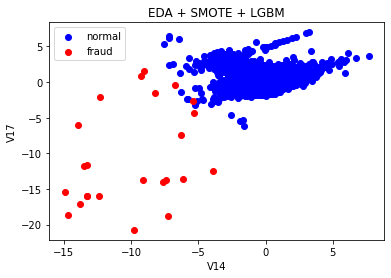

In [160]:
plt.scatter(val[val_pred_xgb2==0]['V14'], val[val_pred_xgb2==0]['V17'], color='blue', label='normal')
plt.scatter(val[val_pred_xgb2==1]['V14'], val[val_pred_xgb2==1]['V17'], color='red', label='fraud')

plt.title('EDA + SMOTE + LGBM')
plt.xlabel('V14')
plt.ylabel('V17')

plt.legend()

plt.show()

In [167]:
ensem4 = 0.5*val_prob_xgb + 0.5*val_prob_xgb2

In [168]:
prediction4 = []

for i in range(len(ensem4)):
  if ensem4[i][0] > ensem4[i][1]:
    prediction4.append(0)
  else:
    prediction4.append(1)

In [171]:
f1_score(val_class,prediction4, average='macro')

0.928501090244074

In [162]:
test_prob_lgbm4 = xgb2.predict_proba(test)

In [163]:
test_ensem4 = 0.5*test_prob_xgb + 0.5*test_prob_lgbm4

In [164]:
test_prediction4 = []

for i in range(len(test_ensem4)):
  if test_ensem4[i][0] > test_ensem4[i][1]:
    test_prediction4.append(0)
  else:
    test_prediction4.append(1)

In [177]:
submission.Class = test_prediction4

In [178]:
submission.to_csv('submission_oversampling_ensemble4.csv', index=False)